In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'E:/ML_PROJECTS/CATS_AND_DOGS/train'
TEST_DIR = 'E:/ML_PROJECTS/CATS_AND_DOGS/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic') # just so we remember which model is which, sizes must match

In [2]:
# Conversion to one-hot array [cat,dog]
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()
# if you already have train data:
#train_data = np.load('train_data.py')

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:56<00:00, 141.25it/s]


In [11]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [14]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from E:\ML_PROJECTS\CATS_AND_DOGS\dogsvscats-0.001-2conv-basic.model
Model Loaded!


In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.40886 | time: 67.360s
| Adam | epoch: 005 | loss: 0.40886 - acc: 0.8027 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.41263 | time: 68.547s
| Adam | epoch: 005 | loss: 0.41263 - acc: 0.7975 | val_loss: 0.48882 - val_acc: 0.7600 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:E:\ML_PROJECTS\CATS_AND_DOGS\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


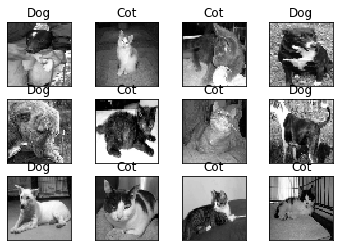

In [16]:
import matplotlib.pyplot as plt

# if you dont have it yet
# test_data = process_test_data()

# if you already have it
test_data = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    #cat: [1,0]
    #dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cot'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

In [ ]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')

In [18]:
with open('submission-file.csv','w') as f:
    for data in tqdm(test_data):
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:29<00:00, 420.62it/s]
